# Vectorstores and Embeddings

Recall the overall workflow for retrieval augmented generation (RAG):

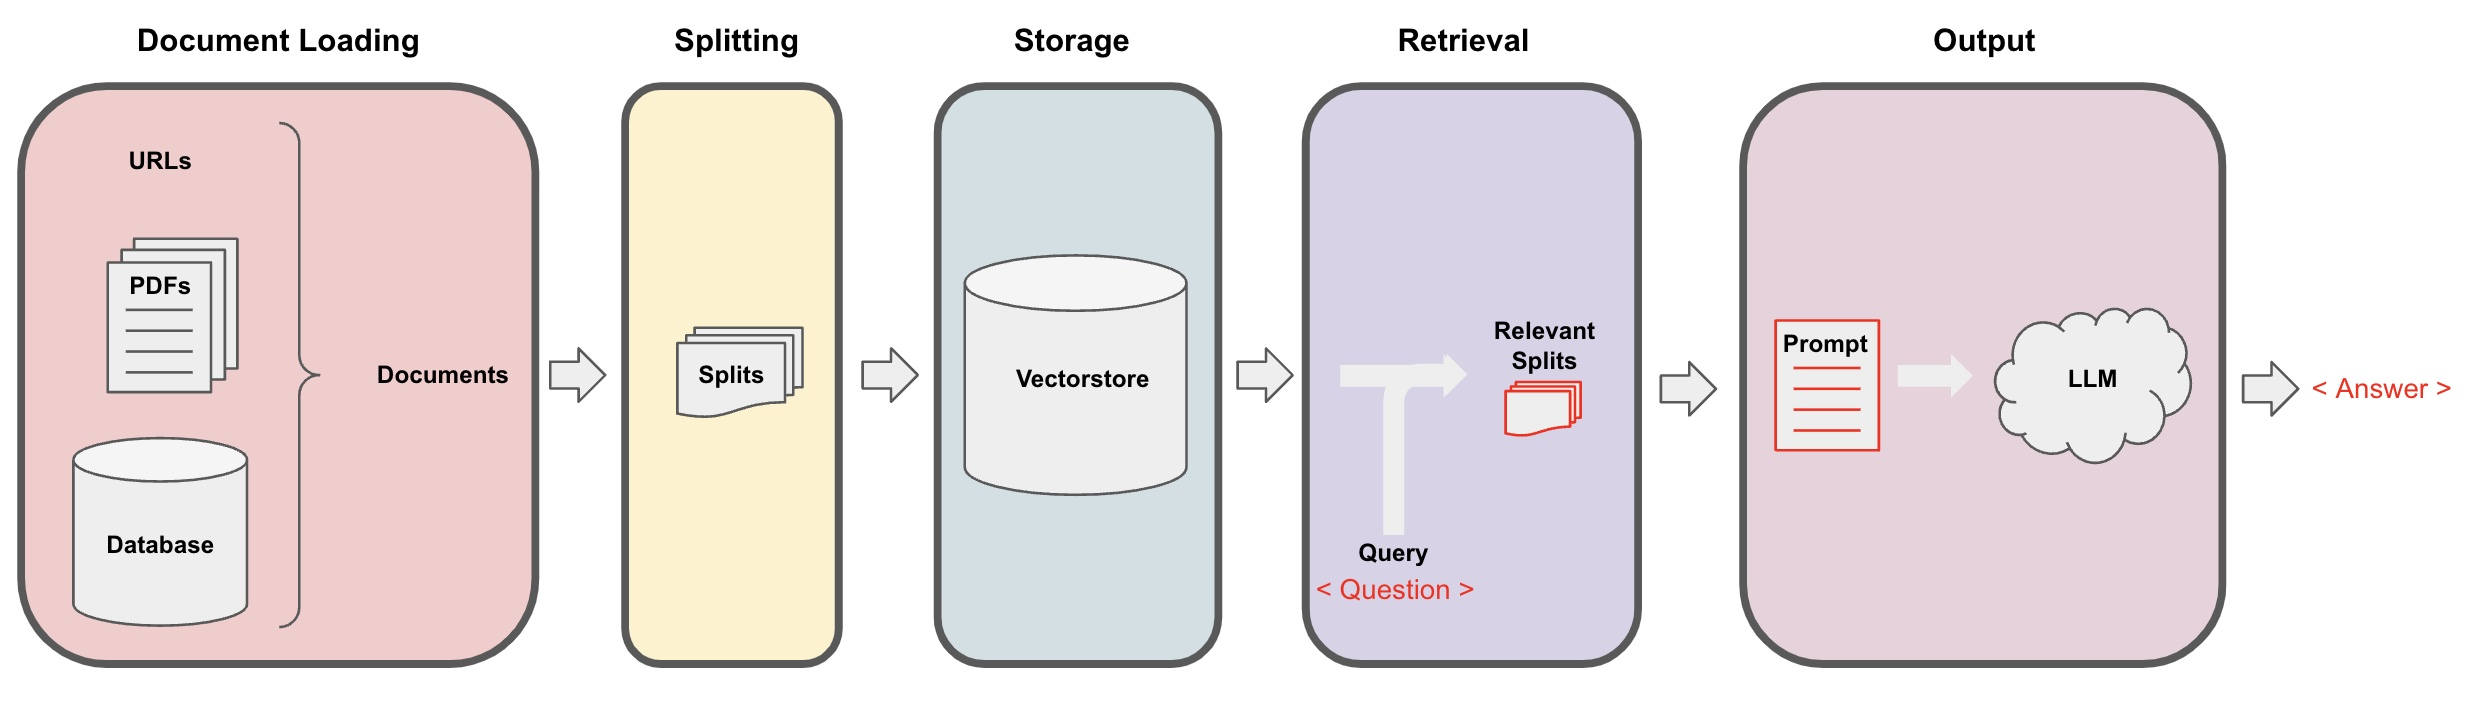

In [1]:
import os
import openai
import sys
sys.path.append('../..')

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

openai.api_key  = os.environ['OPENAI_API_KEY']

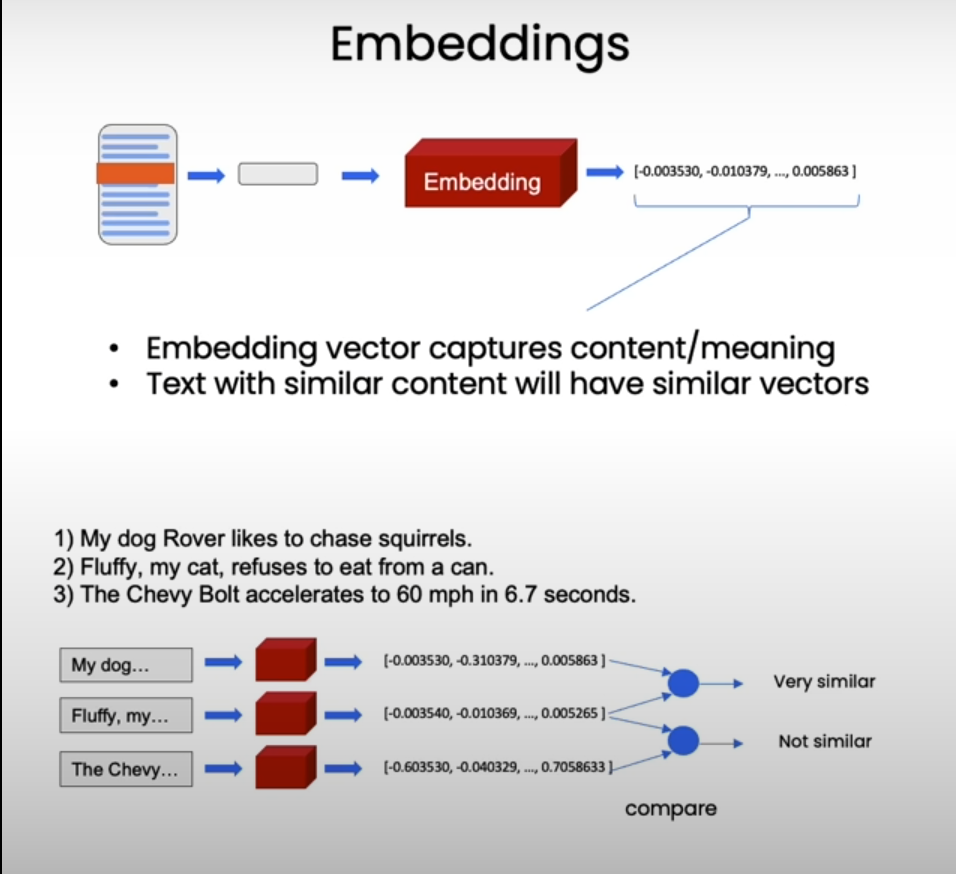

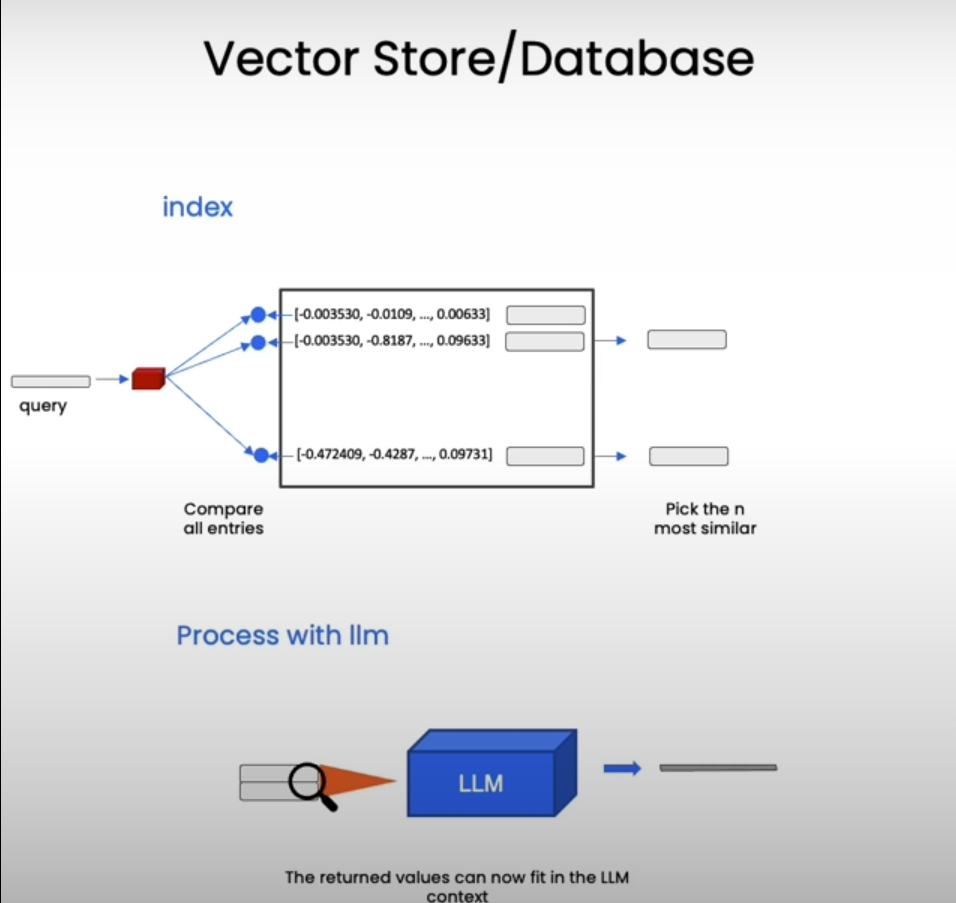

We just discussed `Document Loading` and `Splitting`.

In [2]:
from langchain.document_loaders import PyPDFLoader

# Load PDF
loaders = [
    # Duplicate documents on purpose - messy data
    PyPDFLoader("docs/cs229_lectures/MachineLearning-Lecture01.pdf"),
    PyPDFLoader("docs/cs229_lectures/MachineLearning-Lecture01.pdf"),
    PyPDFLoader("docs/cs229_lectures/MachineLearning-Lecture02.pdf"),
    PyPDFLoader("docs/cs229_lectures/MachineLearning-Lecture03.pdf")
]
docs = []
for loader in loaders:
    docs.extend(loader.load())

In [3]:
# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1500,
    chunk_overlap = 150
)

In [4]:
splits = text_splitter.split_documents(docs)

In [5]:
len(splits)

209

## Embeddings

Let's take our splits and embed them.

In [6]:
from langchain.embeddings.openai import OpenAIEmbeddings
embedding = OpenAIEmbeddings()

In [7]:
sentence1 = "i like dogs"
sentence2 = "i like canines"
sentence3 = "the weather is ugly outside"

In [8]:
embedding1 = embedding.embed_query(sentence1)
embedding2 = embedding.embed_query(sentence2)
embedding3 = embedding.embed_query(sentence3)

In [9]:
import numpy as np

In [10]:
np.dot(embedding1, embedding2)

0.9630351468341317

In [11]:
np.dot(embedding1, embedding3)

0.7701147942700532

In [12]:
np.dot(embedding2, embedding3)

0.7591130371091993

## Vectorstores

In [13]:
# ! pip install chromadb

In [14]:
from langchain.vectorstores import Chroma

In [15]:
persist_directory = 'docs/chroma/'

In [16]:
!rm -rf ./docs/chroma  # remove old database files if any

In [17]:
vectordb = Chroma.from_documents(
    documents=splits,
    embedding=embedding,
    persist_directory=persist_directory
)

In [18]:
print(vectordb._collection.count())

209


### Similarity Search

In [19]:
question = "is there an email i can ask for help"

In [20]:
docs = vectordb.similarity_search(question,k=3)

In [21]:
len(docs)

3

In [22]:
docs[0].page_content

"cs229-qa@cs.stanford.edu. This goes to an acc ount that's read by all the TAs and me. So \nrather than sending us email individually, if you send email to this account, it will \nactually let us get back to you maximally quickly with answers to your questions.  \nIf you're asking questions about homework probl ems, please say in the subject line which \nassignment and which question the email refers to, since that will also help us to route \nyour question to the appropriate TA or to me  appropriately and get the response back to \nyou quickly.  \nLet's see. Skipping ahead — let's see — for homework, one midterm, one open and term \nproject. Notice on the honor code. So one thi ng that I think will help you to succeed and \ndo well in this class and even help you to enjoy this cla ss more is if you form a study \ngroup.  \nSo start looking around where you' re sitting now or at the end of class today, mingle a \nlittle bit and get to know your classmates. I strongly encourage you to f

Let's save this so we can use it later!

In [23]:
vectordb.persist()

## Failure modes

This seems great, and basic similarity search will get you 80% of the way there very easily. 

But there are some failure modes that can creep up. 

Here are some edge cases that can arise - we'll fix them in the next class.

In [24]:
question = "what did they say about matlab?"

In [25]:
docs = vectordb.similarity_search(question,k=5)

Notice that we're getting duplicate chunks (because of the duplicate `MachineLearning-Lecture01.pdf` in the index).

Semantic search fetches all similar documents, but does not enforce diversity.

`docs[0]` and `docs[1]` are indentical.

In [26]:
docs[0]

Document(page_content='those homeworks will be done in either MATLA B or in Octave, which is sort of — I \nknow some people call it a free ve rsion of MATLAB, which it sort  of is, sort of isn\'t.  \nSo I guess for those of you that haven\'t s een MATLAB before, and I know most of you \nhave, MATLAB is I guess part of the programming language that makes it very easy to write codes using matrices, to write code for numerical routines, to move data around, to \nplot data. And it\'s sort of an extremely easy to  learn tool to use for implementing a lot of \nlearning algorithms.  \nAnd in case some of you want to work on your  own home computer or something if you \ndon\'t have a MATLAB license, for the purposes of  this class, there\'s also — [inaudible] \nwrite that down [inaudible] MATLAB — there\' s also a software package called Octave \nthat you can download for free off the Internet. And it has somewhat fewer features than MATLAB, but it\'s free, and for the purposes of  this class,

In [27]:
docs[1]

Document(page_content='those homeworks will be done in either MATLA B or in Octave, which is sort of — I \nknow some people call it a free ve rsion of MATLAB, which it sort  of is, sort of isn\'t.  \nSo I guess for those of you that haven\'t s een MATLAB before, and I know most of you \nhave, MATLAB is I guess part of the programming language that makes it very easy to write codes using matrices, to write code for numerical routines, to move data around, to \nplot data. And it\'s sort of an extremely easy to  learn tool to use for implementing a lot of \nlearning algorithms.  \nAnd in case some of you want to work on your  own home computer or something if you \ndon\'t have a MATLAB license, for the purposes of  this class, there\'s also — [inaudible] \nwrite that down [inaudible] MATLAB — there\' s also a software package called Octave \nthat you can download for free off the Internet. And it has somewhat fewer features than MATLAB, but it\'s free, and for the purposes of  this class,

We can see a new failure mode.

The question below asks a question about the third lecture, but includes results from other lectures as well.

In [28]:
question = "what did they say about regression in the third lecture?"

In [29]:
docs = vectordb.similarity_search(question,k=5)

In [30]:
for doc in docs:
    print(doc.metadata)

{'source': 'docs/cs229_lectures/MachineLearning-Lecture03.pdf', 'page': 0}
{'source': 'docs/cs229_lectures/MachineLearning-Lecture03.pdf', 'page': 14}
{'source': 'docs/cs229_lectures/MachineLearning-Lecture02.pdf', 'page': 0}
{'source': 'docs/cs229_lectures/MachineLearning-Lecture03.pdf', 'page': 6}
{'source': 'docs/cs229_lectures/MachineLearning-Lecture01.pdf', 'page': 8}


In [31]:
print(docs[4].page_content)

into his office and he said, "Oh, professo r, professor, thank you so much for your 
machine learning class. I learned so much from it. There's this stuff that I learned in your 
class, and I now use every day. And it's help ed me make lots of money, and here's a 
picture of my big house."  
So my friend was very excited. He said, "W ow. That's great. I'm glad to hear this 
machine learning stuff was actually useful. So what was it that you learned? Was it 
logistic regression? Was it the PCA? Was it the data ne tworks? What was it that you 
learned that was so helpful?" And the student said, "Oh, it was the MATLAB."  
So for those of you that don't know MATLAB yet, I hope you do learn it. It's not hard, 
and we'll actually have a short MATLAB tutori al in one of the discussion sections for 
those of you that don't know it.  
Okay. The very last piece of logistical th ing is the discussion s ections. So discussion 
sections will be taught by the TAs, and atte ndance at discussion secti